# 10-714 Project: DeepDream in Needle

Bo Lei, Evan Trop, and Drew Moses

Code can be found at: https://drive.google.com/drive/folders/1m58HnKmcrRioAODqV4iDB1dGKaHVdzqs?usp=sharing

## Intro

For our project, we chose to implement DeepDream in needle, using TensorFlow’s [DeepDream tutorial](https://www.tensorflow.org/tutorials/generative/deepdream) as a primary resource. In DeepDream, you take a pretrained image classification model, and you perform gradient ascent on an input image so that it maximally activates a particular hidden layer (or group of layers) in the model. This creates “dream-like” images, and sheds light on what the network’s layers are focused on at various stages of the model. So, as you move from activating earlier layers to activating later layers, increasingly complex patterns can be expected to emerge.

Our project has a few main steps. We will begin by transferring a large pretrained CNN model into needle, but before we can do that, we need to expand the functionality of the needle framework to support the special layers contained in these big CNNs. To do this, we added max pooling and average pooling layers (which the course staff is no doubt familiar with), as well as adaptive average pooling layers (which are a bit more complicated and we will discuss briefly later).

From here, we can transfer models. We chose to transfer the model VGG16, which was trained on the ImageNet dataset. The general approach here was to load the pretrained model in PyTorch, and for each of its layers, we’d extract the weight matrices into numpy arrays, and use those arrays (along with any additional information like input and output dimension, stride, etc) to create and populate an identical layer in needle.

We wrote comprehensive tests to check our new layer types and our ability to transfer layers and models, and we found that our needle implementations lead to essentially identical outputs and gradients as the PyTorch implementations.

Finally, with a pretrained CNN loaded into needle, we could use it to optimize an input image. The general process behind enhancing the activations of the selected convolutional layer in an arbitrary input image first involves creating a model that carries out a forward pass on the pretrained model up to and including the layer of interest. The activations of the last layer are passed into a loss function which is defined simply as the sum of activations. The gradient of the loss with respect to the input image is calculated, scaled by a learning rate, and added to the original input image. This process is carried out based on how much one would like to express the features of the selected layer in the image.

## Code setup
1. Download the project from https://drive.google.com/drive/folders/1m58HnKmcrRioAODqV4iDB1dGKaHVdzqs?usp=sharing
2. Upload the zip file to the colab environment.
3. Unzip the file (done below).

In [ ]:
# Unzip the file downloaded from the above link. The name of the file can be different.
#!unzip -q /content/10714-needle-deepdream-20211213T044018Z-001.zip

from google.colab import drive
drive.mount('/content/drive')


%cd /content/drive/Othercomputers/My MacBook Pro/10714-needle-deepdream

Mounted at /content/drive
/content/drive/Othercomputers/My MacBook Pro/10714-needle-deepdream


In [ ]:
import sys
sys.path.append('./python')

import torch
import numpy as np
import needle as ndl
from needle import nn
from needle.numpy_backend import NumpyDevice

## Pooling Layers

We extend our needle framework by providing pooling layers that are commonly found in CNNs. Max Pooling, Average Pooling and Adaptive Average Pooling layers for 4D input (N,C,H,W) are implemented in `python/needle/nn.py`. They are supported by `MaxPoolOp`, `AvgPoolOp`, `AdaptiveAvgPoolOp` in `python/needle/ops.py` and `max_pool`, `avg_pool`, `adaptive_avg_pool` in `python/needle/nd_backend.py`. We test the functionality of these pooling layers by comparing them to PyTorch layers and the tests can be found in `tests/test_pooling.py`.

Some details of the implementation:
- The forward pass of max pooling and average pooling divides a matrix into tiles using strides, then applies max/average to these tiles.
- The backward pass of these operations is implemented simply by finding the tile corresponding to each output element and updating the gradient.
- As for adaptive average pooling, the general idea of this layer is to allow a CNN to receive inputs of varying sizes. In the typical setup for a large CNN, a series of convolutional layers will be followed by flattening the image before sending it through a set of linear layers. However, these linear layers of course require a consistently sized input. So, an adaptive average pooling layer is used before this flattening step in order to accomodate for arbitrary input sizes. It knows what size the output needs to be, and computes hyperparameters like kernel size on the fly to achieve the desired output dimension for the specific input shape. This is a common approach used across the pretrained torchvision models.
- For adaptive average pooling, the stride can actually be inconsistent *within* an application on a single image (as described in this [forum post](https://discuss.pytorch.org/t/what-is-adaptiveavgpool2d/26897)), and the starting and ending indices are calculated for each tile to be averaged. The PyTorch implementation at https://github.com/pytorch/pytorch/blob/master/aten/src/ATen/native/cuda/AdaptiveAveragePooling.cu is used as reference.


In [ ]:
!python3 -m pytest -l -v tests/test_pooling.py

============================= test session starts ==============================
platform linux -- Python 3.7.12, pytest-3.6.4, py-1.11.0, pluggy-0.7.1 -- /usr/bin/python3
cachedir: .pytest_cache
rootdir: /content/10714-needle-deepdream, inifile:
plugins: typeguard-2.7.1
collected 3 items                                                              

tests/test_pooling.py::test_max_pool PASSED                              [ 33%]
tests/test_pooling.py::test_avg_pool PASSED                              [ 66%]
tests/test_pooling.py::test_adaptive_avg_pool PASSED                     [100%]

=========================== 3 passed in 3.08 seconds ===========================


## Transferring Layers and Models

With code written to expand needle’s layers, we can now transfer over large pretrained models from PyTorch to needle. The code to do this is contained in needle/transfer.py, and we can test it similarly to the homework tests using tests/test_transfer.py.

Separate code is needed to transfer over each layer type. Some layers, like max pooling, can be transferred easily, as we only need to extract a couple pieces of information like stride and kernel size. Others, like linear or convolutional layers, are a bit more tricky, as we need to populate the data stored in the needle layer correctly. For this reason, we have separate tests for transferring linear and convolutional layers, in addition to tests for transferring entire models.

A few more interesting notes on this section:
- The weights for linear and convolutional layers are stored in different orientations in the two frameworks, so we need to perform transposes on the weight and gradient values in order to transfer layers and check them successfully.
- We chose not to transfer the dropout layers, as DeepDream does not actually train the CNN. So to make the models consistent during tests, we removed the dropout layers from the pytorch models (or sometimes equivalently set the model to eval mode).
- The PyTorch version of VGG16 doesn’t require an explicit flatten() layer before the linear layers, but our needle implementation has to include one.


In [ ]:
!python3 -m pytest -l -v tests/test_transfer.py

============================= test session starts ==============================
platform linux -- Python 3.7.12, pytest-3.6.4, py-1.11.0, pluggy-0.7.1 -- /usr/bin/python3
cachedir: .pytest_cache
rootdir: /content/10714-needle-deepdream, inifile:
plugins: typeguard-2.7.1
collected 3 items                                                              

tests/test_transfer.py::test_transfer_linear PASSED                      [ 33%]
tests/test_transfer.py::test_transfer_conv PASSED                        [ 66%]
tests/test_transfer.py::test_transfer_VGG16 PASSED                       [100%]

========================== 3 passed in 72.06 seconds ===========================


## Importing Images

In `needle.image_process.py` we've defined functions for reading in an image from an image url, cropping to desired dimension, processing an image in the same manner that images were processed for training VGG16 in pytorch, as well as functions to generate/display gifs. The code block below reads in a cat and landscape image, crops to the desired size, and displays.

Landscape Input


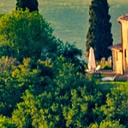


Cat Input


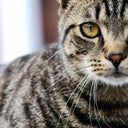

In [ ]:
from needle.img_process import *

#Import and Display Images
imgMap = {}
url = "https://a.cdn-hotels.com/gdcs/production163/d1408/68d2e41a-175d-4104-bc85-36be5656aa09.jpg"
imgMap['landscape'] = import_img(url,maxDim = 128)

print("Landscape Input")
display(imgMap['landscape'])

url = "https://styles.redditmedia.com/t5_2qnlf/styles/communityIcon_bckbrah432281.jpg?width=256&s=4bb6ea857139ce6a5e1bd7e71fe238387839758a"
imgMap['cat'] = import_img(url,maxDim = 128)

print()
print("Cat Input")
display(imgMap['cat'])

## Enhancing the Selected Layer in Your Input Image

In `apps/models.py` we've defined a Deep Dream Model class `DD_Model` which takes in a list of modules corresponding to the layers of the pretrained model as well as the convolutional layer that we wish to enhance. 

The `DD_Model.forward` function takes as input an arbitrary image with pixel values in [0,1] and does a forward pass so that the layer of interest is set as the "output layer".

The backward pass is called on our loss function, `DD_Loss`, defined as a Module in `ndl.nn.py`. The loss is currently the sum of the activations in the "output layer".

The gradients are propogated backwards through the network. However, no parameters are updated since we do not wish to optimize the network but rather the activations of our desired convolutional layer for this image. Once the gradient of our loss function w.r.t to the input image is calculated we update the image using gradient ascent defined as an Optimizer class, `GradAscent`, in `ndl.optim.py`. Before the gradient is used in updating the image they are normalized by the standard deviation.

The `EnhanceImage` function defined  below takes as input a 1 x H x W x C `Tensor` corresponding to the input image, a `DD_Model` Module, `DD_Loss` Module, `GradAscent` optimmizer, number of iterations, and learning rate.

The function will carry out the process outlined above for the specified number of iterations. At each iteration the current image and loss are appended to separate list.

In [ ]:
sys.path.append('./python')
sys.path.append('./apps')

import needle as ndl
from needle import nn, ops
from needle import transfer

import models
from needle import backend_ndarray as nd
from needle import optim

import torchvision.models as tvModels
from needle import transfer


def EnhanceImage(img: ndl.Tensor ,Model :nn.Module, loss_fn = nn.DD_Loss(),
                   optimizer = optim.GradAscent, iters = 20,lr = .01):
  
  Model.train() #In order to propogate gradients

  lossList = []
  imgs = [numpy_to_PIL(deprocess(img.data.numpy().transpose((0,2,3,1))))] # A list of Image objects.TENSOR->NP->IMAGE


  for i in range(iters):
    #Forward
    out = Model(img)
    loss = loss_fn(out.transpose((1,2)).transpose((2,3)))
    lossList.append(loss.data.numpy())

    #Backward
    loss.backward()

    #Gradient Ascent
    opt = optimizer(img,lr = lr)
    opt.step()
    
    imgs.append(numpy_to_PIL(deprocess(img.data.numpy().transpose((0,2,3,1)))))

  print("Done Enhancing!\n")
  
  return lossList,imgs

## Putting Everything Together

In the following three code blocks we:
1. cast our input image as a Tensor, 
2. download the pretrained VGG16 network as a pytorch model
3. transfer the pytorch model to a needle model 
4. enhance the selected layer defined by the `layer` var in the input image 
5. display the loss function over the enhancement process


In [ ]:
#Set device as cpu/cuda
device = ndl.cpu()

#PIL Image to nump array, add batch dimension, and permute axes to required input 
#For Conv forward pass, all pixels values in [0,1] + torch normalization
img = np.array(imgMap['landscape'], dtype = np.float32)
img = preprocess(img)

#Cast input image (N x C x H x W) as a needle Tensor backed by a ndArray 
imgT = ndl.Tensor(nd.array(img),device= device, dtype= "float32")
print("Image Tensor Shape -", imgT.shape,"\n")

Image Tensor Shape - (1, 3, 128, 128) 



In [ ]:
#Transfer VGG16 from Pytorch to Needle framework
preTrained = tvModels.vgg16(pretrained=True).features
ndl_preTrained = transfer.transfer_model(preTrained,tag = "VGG16start")

#Obtain Convolutional Layers
convLayers = []
for module in ndl_preTrained.modules:
  if isinstance(module, nn.Conv):
    convLayers.append(module)
    
print()
print(f"There are {len(convLayers)} convolutional layers to pick from!\n")

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

[<needle.nn.Conv object at 0x7f0f3ae8ec10>, <needle.nn.ReLU object at 0x7f1042400490>, <needle.nn.Conv object at 0x7f1048ef0990>, <needle.nn.ReLU object at 0x7f0f3a6f4c90>, <needle.nn.MaxPool object at 0x7f0f3a6f4690>, <needle.nn.Conv object at 0x7f0f3a6f4950>, <needle.nn.ReLU object at 0x7f0f3d49b210>, <needle.nn.Conv object at 0x7f0f3d49b850>, <needle.nn.ReLU object at 0x7f0f3a6d52d0>, <needle.nn.MaxPool object at 0x7f0f3a6f4d90>, <needle.nn.Conv object at 0x7f0f3a6d5190>, <needle.nn.ReLU object at 0x7f0f3a6d5f10>, <needle.nn.Conv object at 0x7f0f3a6d5390>, <needle.nn.ReLU object at 0x7f0f3a6d5e50>, <needle.nn.Conv object at 0x7f0f3a698310>, <needle.nn.ReLU object at 0x7f0f3a6980d0>, <needle.nn.MaxPool object at 0x7f0f3a698450>, <needle.nn.Conv object at 0x7f0f3a698090>, <needle.nn.ReLU object at 0x7f0f3a698910>, <needle.nn.Conv object at 0x7f0f3a698810>, <needle.nn.ReLU object at 0x7f0f3a698c10>, <needle.nn.Conv object at 0x7f0f3a698950>, <needle.nn.ReLU object at 0x7f0f3a698f10>, <

Done Enhancing!



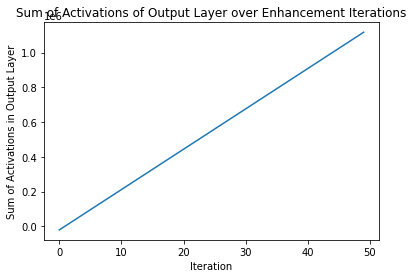

In [ ]:
#Select conv layer [0,number of convLayers]
layer = 0

#Create Deep Dream Model
Model = models.DD_Model(ndl_preTrained.modules,convLayers[layer])

#Enhance image 
loss, imgList = EnhanceImage(imgT,Model,iters = 50, lr = 0.1)

#Plot Loss over Iterations
plot_loss(loss)

## A View of the Enhancement Process and Final Image 

This last code block displays the final results of the enhancement as well as a GIF of the image transformation. The gif and final image are saved in       /needle

Final Enhanced Image


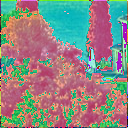


Enhancement Process


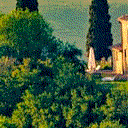

In [ ]:
print("Final Enhanced Image")
display(imgList[-1])
imgList[-1].save(f'Landscape_Layer{layer}.png')
print()
print("Enhancement Process")
generate_gif(imgList,f"Landscape_Layer{layer}.gif")
display_gif(f"Landscape_Layer{layer}.gif")

The above displays the result of the EnhanceImage function with parameters:

- Convolutional Layer 0
- 50 iterations
- learing rate = .1

The result is very interesting, as it appears that different color schemes are enhanced in the image rather than changing the geometry of any of the objects in the image. Intuitively this makes sense, as the first convolutional layer is likely learning more simple ideas like how colors are related to one another. It seems that the image evolves through ~7 different color schemes just during these 50 iterations.

## Testing Out Other Images/ Layers

We try enhancing deeper layers and another image!

Done Enhancing!



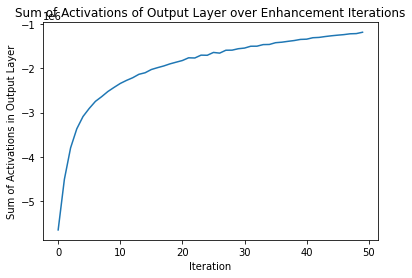

Final Enhanced Image


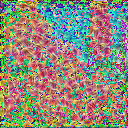


Enhancement Process


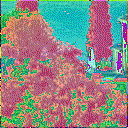

In [ ]:
#Select conv layer [0,number of convLayers]
layer = 6

#Create Deep Dream Model
Model = models.DD_Model(ndl_preTrained.modules,convLayers[layer])

#Enhance image 
loss, imgList = EnhanceImage(imgT,Model,iters = 50, lr = 0.1)

#Plot Loss over Iterations
plot_loss(loss)

print("Final Enhanced Image")
display(imgList[-1])
imgList[-1].save(f'Landscape_Layer{layer}.png')
print()
print("Enhancement Process")
generate_gif(imgList,f"Landscape_Layer{layer}.gif")
display_gif(f"Landscape_Layer{layer}.gif")

The above displays the result of the EnhanceImage function with parameters:

- Convolutional Layer 6
- 50 iterations
- learing rate = .1

Although the images are only 128 x 128 we can see that there is some pattern/texture that is enhanced throughout the image. In this case running too many iterations can cause the image to be overwhelmed by the feature that is trying to be expressed. However, we can still see the rough outline of prominent objects. Because we are only enhancing one layer it makes sense that there is only one repeated pattern. We believe that the frequency of this pattern could be related to the kernel size.

Done Enhancing!



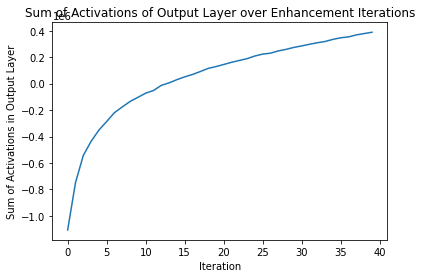

Final Enhanced Image


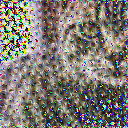


Enhancement Process


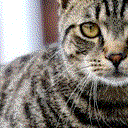

In [ ]:
#Cat image
img = np.array(imgMap['cat'], dtype = np.float32)
img = preprocess(img)

#Cast input image (N x C x H x W) as a needle Tensor backed by a ndArray 
imgT = ndl.Tensor(nd.array(img),device= device, dtype= "float32")


#Select conv layer [0,number of convLayers]
layer = 5

#Create Deep Dream Model
Model = models.DD_Model(ndl_preTrained.modules,convLayers[layer])

#Enhance image 
loss, imgList = EnhanceImage(imgT,Model,iters = 40, lr = 0.1)

#Plot Loss over Iterations
plot_loss(loss)

print("Final Enhanced Image")
display(imgList[-1])
imgList[-1].save(f'Cat_Layer{layer}.png')
print()
print("Enhancement Process")
generate_gif(imgList,f"Cat_Layer{layer}.gif")
display_gif(f"Cat_Layer{layer}.gif")

The above displays the result of the EnhanceImage function with parameters:

- Convolutional Layer 5
- 40 iterations
- learing rate = .01

This results shows some more complex pattern/texture, which appears to be some type of swirl, being enhanced. Its also interesting to note that the white part of the image is more quickly modified, perhaps because that area starts with the least initial texture, and that seems to be what this layer is interested in. 

## Where to find .png and .gif files

The .png and .gif files generated from our tests can be found in `/10714-needle-deepdream/Image_Results` with corresponding labels. 
 

## Future expansions

There are a variety of good places this project could be taken in the future. For example:
- Support could be added for convolutional layers which do not preserve the input size, allowing for transfer of other pretrained models such as AlexNet.
- Enhancements or expanded compute resources could improve our ability to activate later layers, so that we can try to generate larger structures like eyes or faces.
- We could provide support for automatically loading pretrained models from other frameworks, or for loading needle-trained models into other frameworks.